# **Project Work Flow**

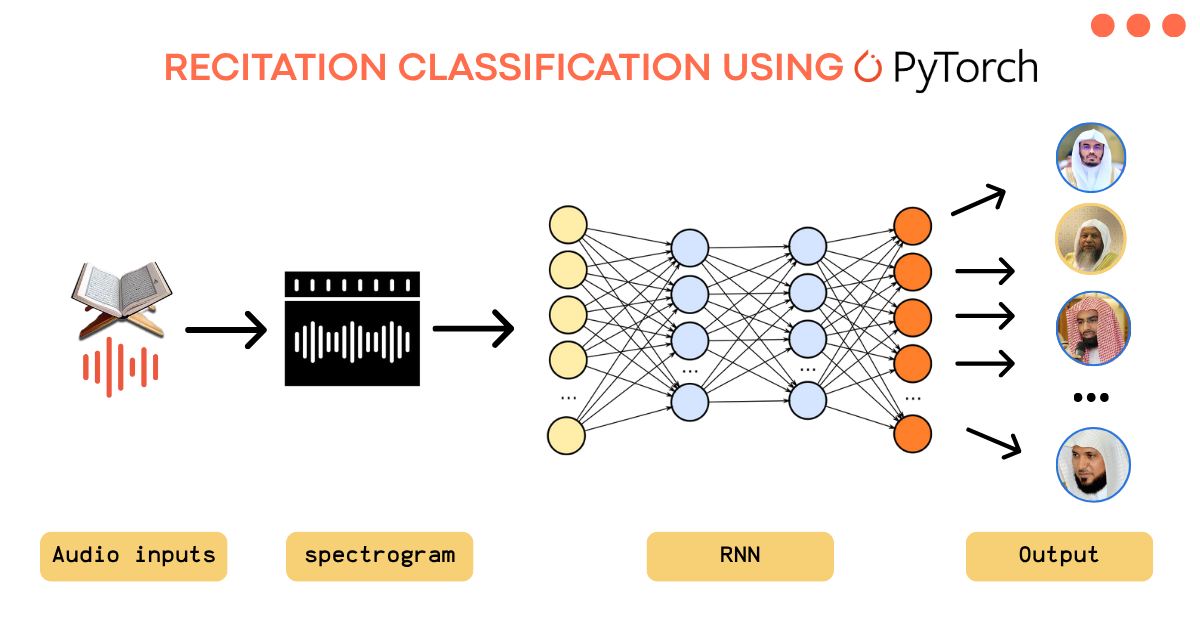

In [1]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize
import seaborn as sns
sns.set_style('white')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("the device we are using is ",device)
import warnings
warnings.filterwarnings('ignore')

the device we are using is  cuda


### **Importing the data**

In [2]:
df = pd.read_csv("/kaggle/input/quran-recitations-for-audio-classification/files_paths.csv")

### **loading the Packages**

### **Data Preprocessing and Cleaning**

Text(0.5, 1.0, 'counts of Classes')

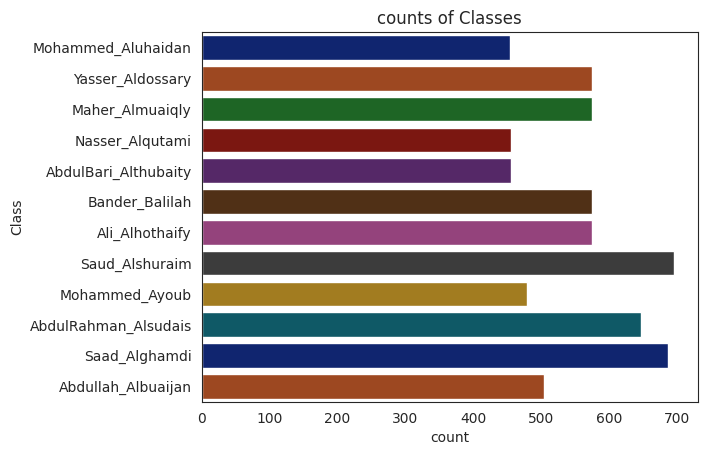

In [3]:
sns.countplot(y=df['Class'],palette='dark')
plt.title('counts of Classes')

In [4]:
df['FilePath'] = '/kaggle/input/quran-recitations-for-audio-classification/Dataset/' + df['FilePath'].str[1:]

In [5]:
df.iloc[1,0]

'/kaggle/input/quran-recitations-for-audio-classification/Dataset//Dataset/Mohammed_Aluhaidan/lohaidan_159.wav'

In [6]:
print("number of observation :",df.shape[0])
print("number of Dimensions :",df.shape[1])

number of observation : 6687
number of Dimensions : 2


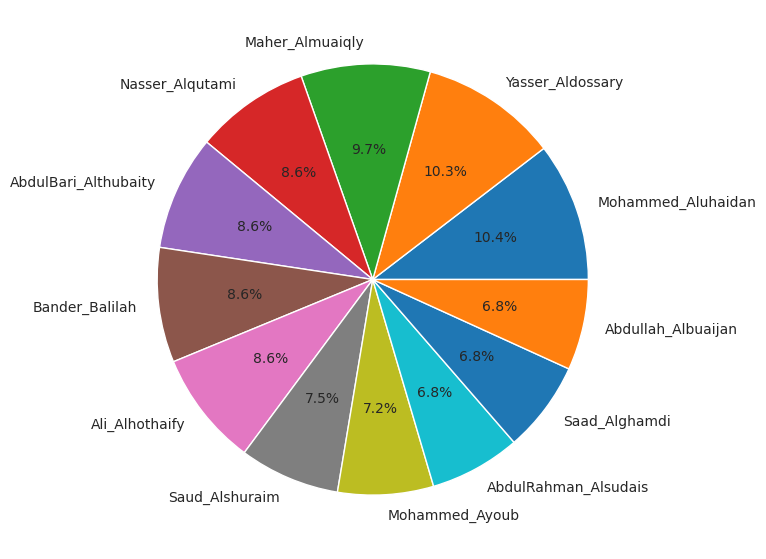

In [7]:
plt.figure(figsize=(7,7))
plt.pie(df['Class'].value_counts(),labels=df['Class'].unique(),autopct='%1.1f%%')
plt.show()

In [8]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

In [9]:
df = df.sample(frac=1,random_state=42)
train = df.sample(frac=0.7,random_state=42)
test = df.drop(train.index)
val = test.sample(frac=0.5,random_state=42)
test = test.drop(val.index)

print('Training data shape:',train.shape[0])
print('validation data shape:',val.shape[0])
print('Testing data shape:',test.shape[0])

Training data shape: 4681
validation data shape: 1003
Testing data shape: 1003


### **Creating Custom Data**

In [10]:
class Custom_audio_data(Dataset):
  def __init__(self,dataframe):
    self.dataframe = dataframe
    self.labels = torch.LongTensor(list(dataframe['Class'])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectogram(file_path)).type(torch.FloatTensor) for file_path in self.dataframe["FilePath"]]
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index,0]
    label = torch.Tensor(self.labels[index]).to(device)
    audio =  self.audios[index].unsqueeze(0).to(device)
    return audio , label
  def get_spectogram(self,file_path):
    sr = 22050
    duration = 5

    image_h = 128
    image_w = 256

    signal,sr = librosa.load(file_path,sr=sr,duration=duration)
    spectogram = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=2048,hop_length=512,n_mels=128)
    spec_db = librosa.power_to_db(spectogram, ref = np.max)

    spec_resized = librosa.util.fix_length(spec_db,size=(duration * sr)//512+1)
    spec_resized = resize(spec_resized,(image_h,image_w),anti_aliasing=True)
    return spec_resized


In [11]:
train_data = Custom_audio_data(dataframe=train)
test_data = Custom_audio_data(dataframe=test)
val_data = Custom_audio_data(dataframe=val)

In [12]:
encoder.inverse_transform([2])

array(['Abdullah_Albuaijan'], dtype=object)

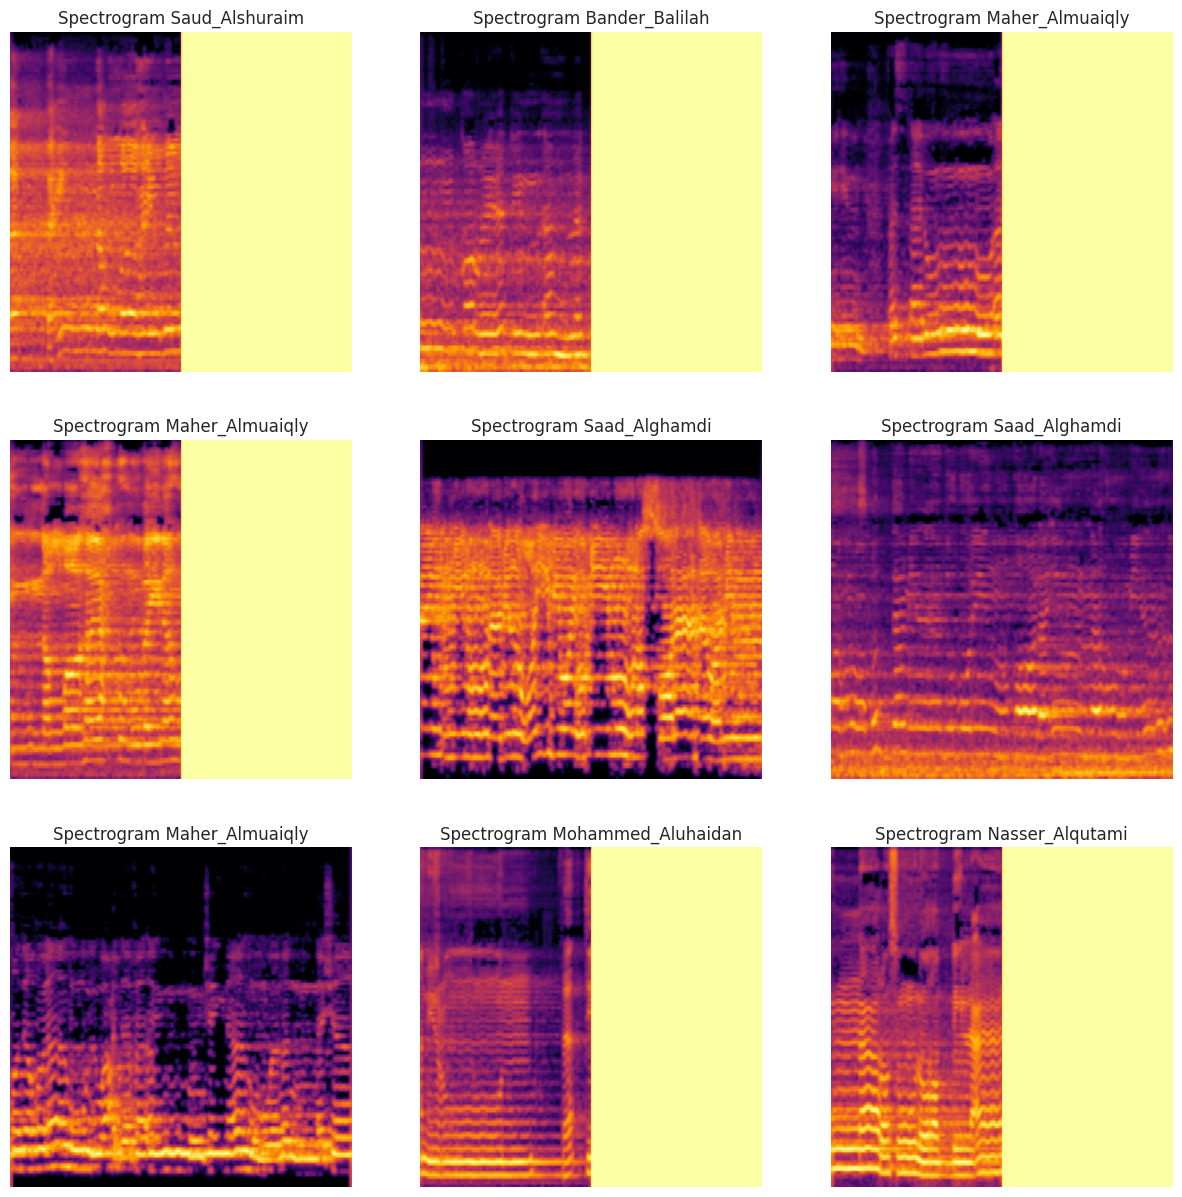

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))  # Increase the figsize for better visibility
ax = ax.flatten()
for i in range(len(ax)):
    idx = np.random.randint(0, len(train_data))  # Get a random index from the dataset
    ax[i].imshow(train_data[idx][0].squeeze(0).cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')
    label = train_data[idx][1].item()
    ax[i].set_title(f'Spectrogram {encoder.inverse_transform([label])[0]}')
    ax[i].axis('off')

### **building our model architecture**

In [14]:
lr = 1e-4
Batch_size = 16
epochs = 25

In [15]:
train_loader = DataLoader(train_data,batch_size=Batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=Batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=Batch_size,shuffle=True)

In [16]:
from torchsummary import summary
class audio_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.con_1 = nn.Conv2d(1,16,kernel_size=3,padding=1)
    self.con_2 = nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.con_3 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.pooling = nn.MaxPool2d(2,2)
    self.ReLu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear((64*16*32),4096)
    self.linear2 = nn.Linear(4096,1024)
    self.linear3 = nn.Linear(1024,512)
    self.output = nn.Linear(512,len(df['Class'].unique()))

    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = self.con_1(x)
    x = self.pooling(x)
    x = self.con_2(x)
    x = self.pooling(x)
    x = self.con_3(x)
    x = self.pooling(x)
    x = self.ReLu(x)

    x = x.view(x.size(0),-1)

    x = self.flatten(x)
    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)

    x = self.linear3(x)
    x = self.dropout(x)

    x = self.output(x)
    return x

Model = audio_model().to(device)
criteron = nn.CrossEntropyLoss()
optimizer = Adam(Model.parameters(),lr=lr)
summary(Model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [17]:
from tqdm.notebook import tqdm

### **building the training loop**

In [18]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

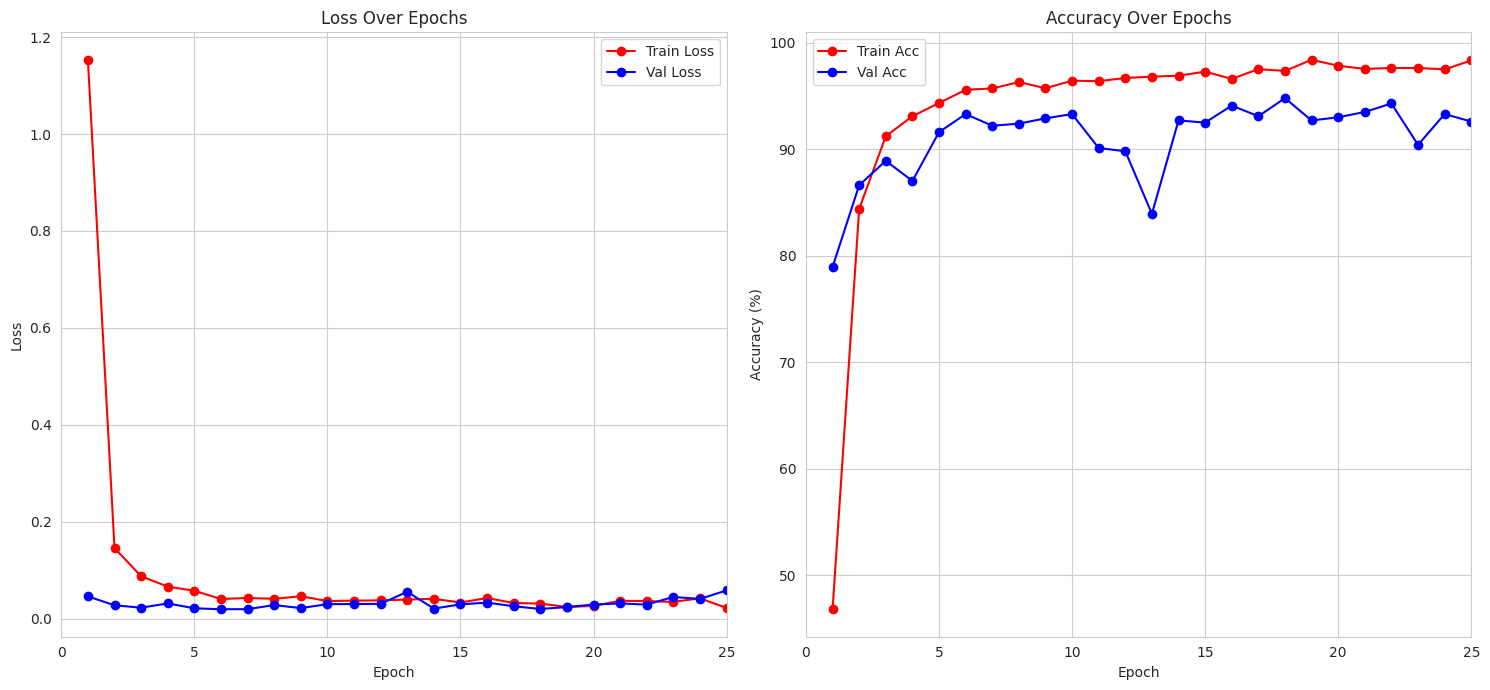

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 24 | Train loss 0.0218 | Train accuracy : 98.355 | Validation Loss : 0.058 | Validation accuracy : 92.6221 
------------------------------------------------------------------------------------------------------------------------------------------------------


In [19]:
sns.set_style("whitegrid")
total_loss_train = []
total_loss_val = []
total_acc_train = []
total_acc_val = []

for ep in tqdm(range(epochs),desc=f'Training the epoch'):
  ep_loss_train = 0
  ep_acc_train = 0
  ep_loss_val = 0
  ep_acc_val = 0

  for input , label in train_loader:
    output = Model(input)

    train_loss = criteron(output,label)
    ep_loss_train+=train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output,axis=1)==label).sum().item()
    ep_acc_train+=train_acc

    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for input ,label in val_loader:
      output = Model(input)

      val_loss = criteron(output,label)
      ep_loss_val+=val_loss.item()

      val_acc = (torch.argmax(output,axis=1)==label).sum().item()
      ep_acc_val+=val_acc

  train_size = len(train_loader.dataset)
  val_size = len(val_loader.dataset)

  total_loss_train.append(round(ep_loss_train/1000,4))
  total_loss_val.append(round(ep_loss_val/1000,4))
  total_acc_train.append(round((ep_acc_train / train_data.__len__())*100,4))
  total_acc_val.append(round((ep_acc_val / val_data.__len__())*100,4))
    # Live Plotting
  clear_output(wait=True)
  plt.figure(figsize=(15, 7))
    
    # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, len(total_loss_train) + 1), total_loss_train, label='Train Loss', marker='o',c='r')
  plt.plot(range(1, len(total_loss_val) + 1), total_loss_val, label='Val Loss', marker='o',c='b')
  plt.xlim(0,epochs)
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
    
    # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, len(total_acc_train) + 1), total_acc_train, label='Train Acc', marker='o',c='r')
  plt.plot(range(1, len(total_acc_val) + 1), total_acc_val, label='Val Acc', marker='o',c='b')
  plt.xlim(0,epochs)         
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()
    
  plt.tight_layout()
  plt.show()
  
  print("---"*50)
  print(f"Epoch : {ep} | Train loss {round(ep_loss_train/1000,4)} | Train accuracy : {round((ep_acc_train / train_size)*100,3 )} | Validation Loss : {round(ep_loss_val/1000,4)} | Validation accuracy : {round((ep_acc_val / val_size )*100,4)} ")
  print("---"*50)



### **Evolution The Model Loss and Accuracy**

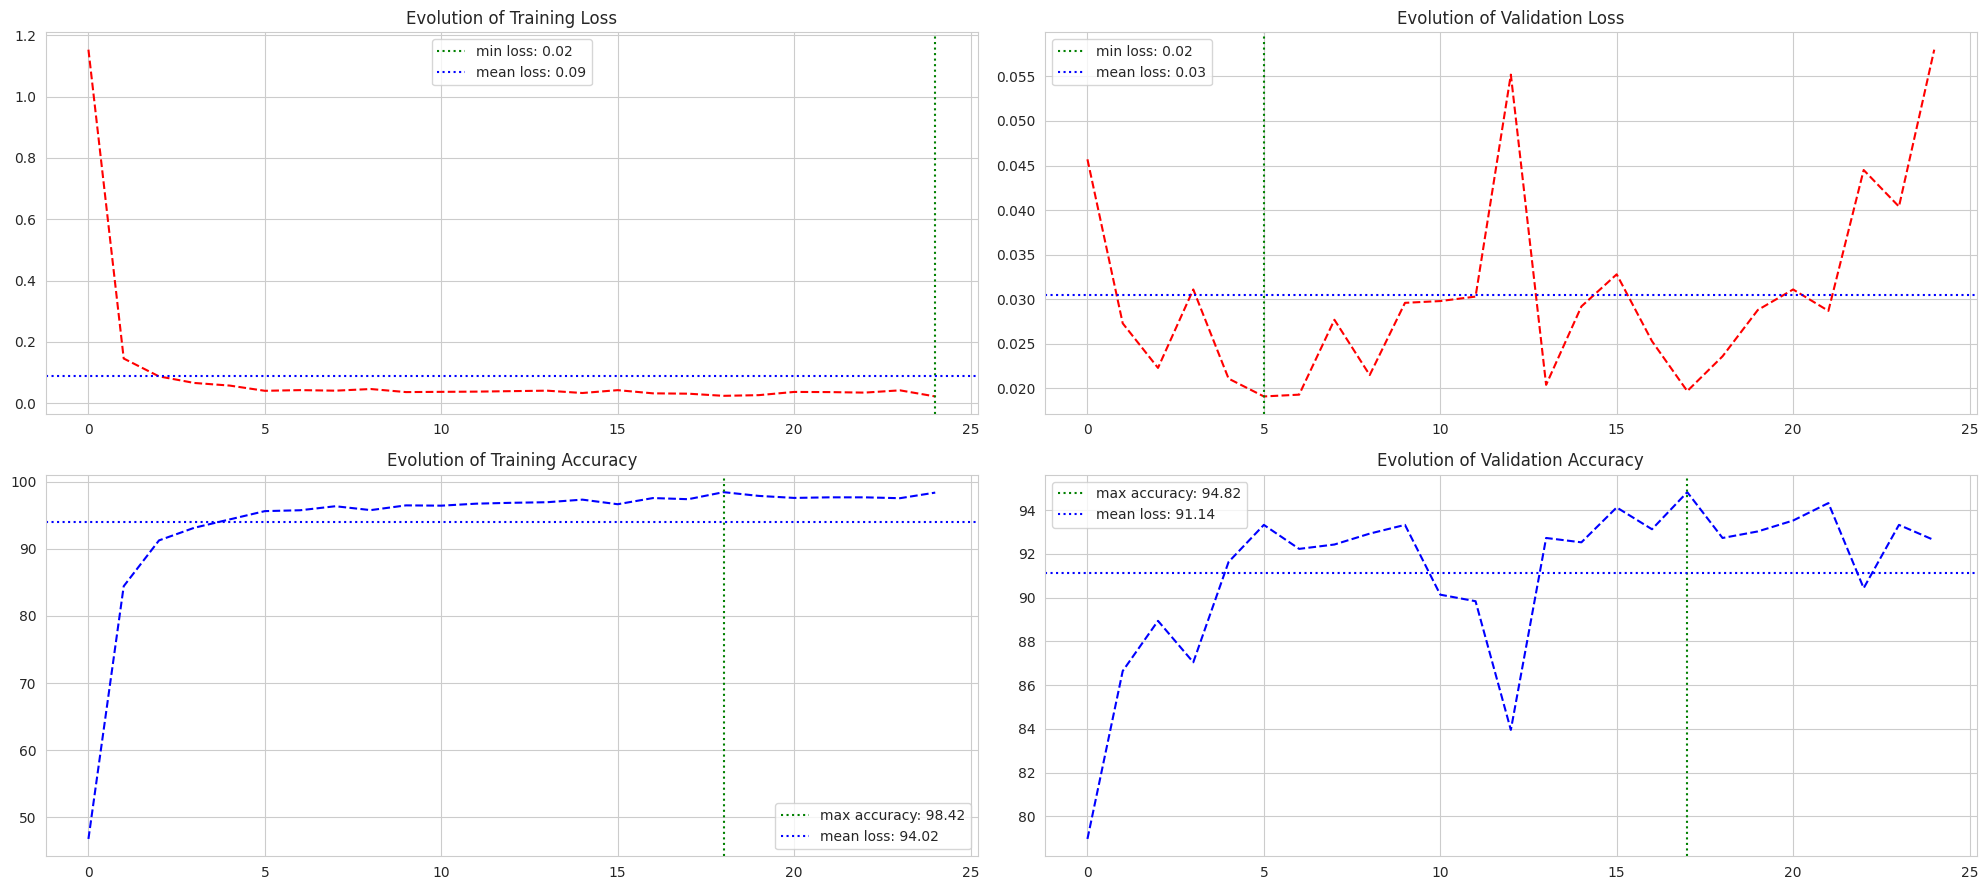

In [20]:
plt.figure(figsize=(20, 9))

# Training Loss Plot
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, epochs), total_loss_train, linestyle='--', c='r')
plt.axvline(np.argmin(total_loss_train),linestyle=':', c='g',label=f"min loss: {round(min(total_loss_train),2)}")
plt.axhline(np.mean(total_loss_train),linestyle=':', c='b',label=f"mean loss: {round(np.mean(total_loss_train),2)}")

plt.title("Evolution of Training Loss")
plt.legend()

# Validation Loss Plot
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, epochs), total_loss_val, linestyle='--', c='r')
plt.axvline(np.argmin(total_loss_val),linestyle=':', c='g',label=f"min loss: {round(min(total_loss_val),2)}")
plt.axhline(np.mean(total_loss_val),linestyle=':', c='b',label=f"mean loss: {round(np.mean(total_loss_val),2)}")
plt.title("Evolution of Validation Loss")
plt.legend()
# Training Accuracy Plot
plt.subplot(2, 2, 3)
plt.plot(np.arange(0, epochs), total_acc_train, linestyle='--', c='b')
plt.axvline(np.argmax(total_acc_train),linestyle=':', c='g',label=f"max accuracy: {round(max(total_acc_train),2)}")
plt.axhline(np.mean(total_acc_train),linestyle=':', c='b',label=f"mean loss: {round(np.mean(total_acc_train),2)}")
plt.title("Evolution of Training Accuracy")
plt.legend()
# Validation Accuracy Plot
plt.subplot(2, 2, 4)
plt.plot(np.arange(0, epochs), total_acc_val, linestyle='--', c='b')
plt.axvline(np.argmax(total_acc_val),linestyle=':', c='g',label=f"max accuracy: {round(max(total_acc_val),2)}")
plt.axhline(np.mean(total_acc_val),linestyle=':', c='b',label=f"mean loss: {round(np.mean(total_acc_val),2)}")
plt.title("Evolution of Validation Accuracy")
plt.legend()
# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### **Testing our Model performance**

In [21]:
total_test_accuracy = 0
sample_size = 0
with torch.inference_mode():
    
    for input , label in test_loader:
        output = Model(input)
        acc = (torch.argmax(output,dim=1)==label).sum().item()
        total_test_accuracy += acc
print(f'The Model accuracy is : {round((total_test_accuracy/test_data.__len__())*100,3)}') 

The Model accuracy is : 90.828
